# **CREATING THE BOT AND TRAINING IT**

**Importing Required Packages.**

In [1]:
!pip install ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from ta import add_all_ta_features
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=bea117dd2605e960316abd33356b590439144fac568744225ec49c2733e048f3
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


**Getting the training dataset and exploring it**

In [2]:
# Replace 'stock_symbol' with the stock symbol you want to analyze
stock_symbol = 'GOOG'
extended_end_date = pd.Timestamp.now() + pd.DateOffset(days=30)
stock_data = yf.download(stock_symbol, start='2021-1-1', end=extended_end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


**Implementing the SMA (Simple Moving Avg) Stratergy**

*   SMA crossover (buy when short-term SMA crosses above long-term SMA, sell when short-term SMA crosses below long-term SMA).


In [3]:
def SMA_strategy(data, short_window=20, long_window=50):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0

    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    signals.loc[signals.index[short_window:], 'signal'] = np.where(
    signals['short_mavg'].iloc[short_window:] > signals['long_mavg'].iloc[short_window:],
    1.0,
    0.0
    )

    signals['positions'] = signals['signal'].diff()

    return signals

signals = SMA_strategy(stock_data)

**Visualizing the statergy**

*  Plotting the stock prices along with buy/sell signals based on the SMA strategy.

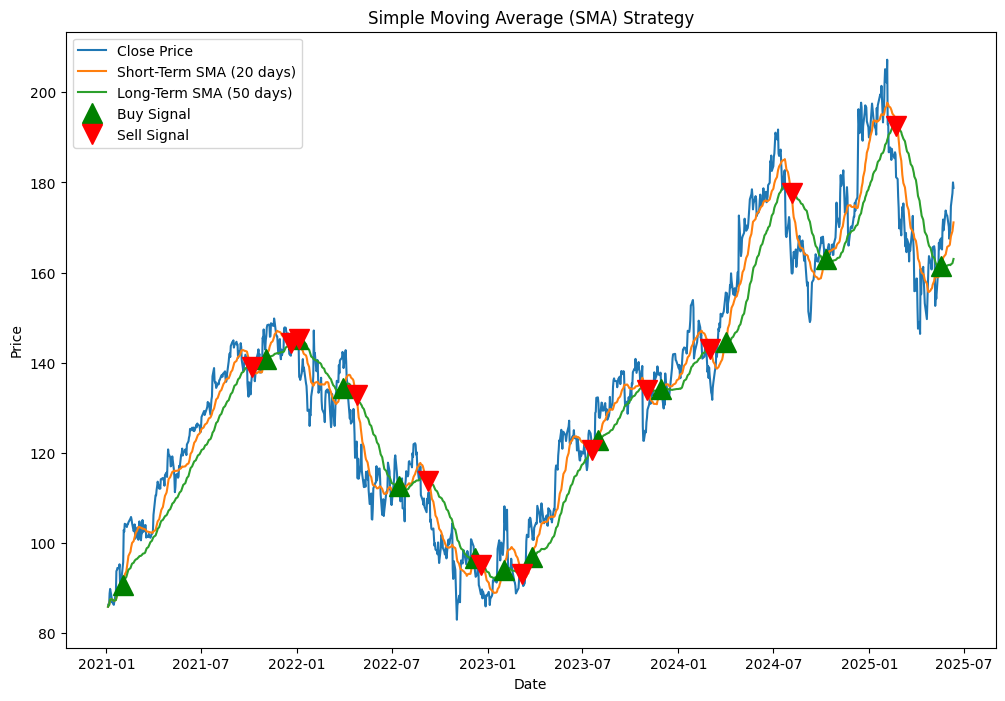

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(stock_data['Close'], label='Close Price')
plt.plot(signals['short_mavg'], label='Short-Term SMA (20 days)')
plt.plot(signals['long_mavg'], label='Long-Term SMA (50 days)')

# Plot bullish behavior
plt.plot(signals[signals['positions'] == 1.0].index,
         signals['short_mavg'][signals['positions'] == 1.0],
         '^', markersize=15, color='g', lw=0, label='Buy Signal')

# Plot bearish behavior
plt.plot(signals[signals['positions'] == -1.0].index,
         signals['short_mavg'][signals['positions'] == -1.0],
         'v', markersize=15, color='r', lw=0, label='Sell Signal')

plt.title('Simple Moving Average (SMA) Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# **IMPLEMENTATION**

**Backtesting and Performance Evaluation**

*  Backtest the strategy by simulating trades based on historical data and evaluating its performance metrics like returns, Sharpe ratio, etc.



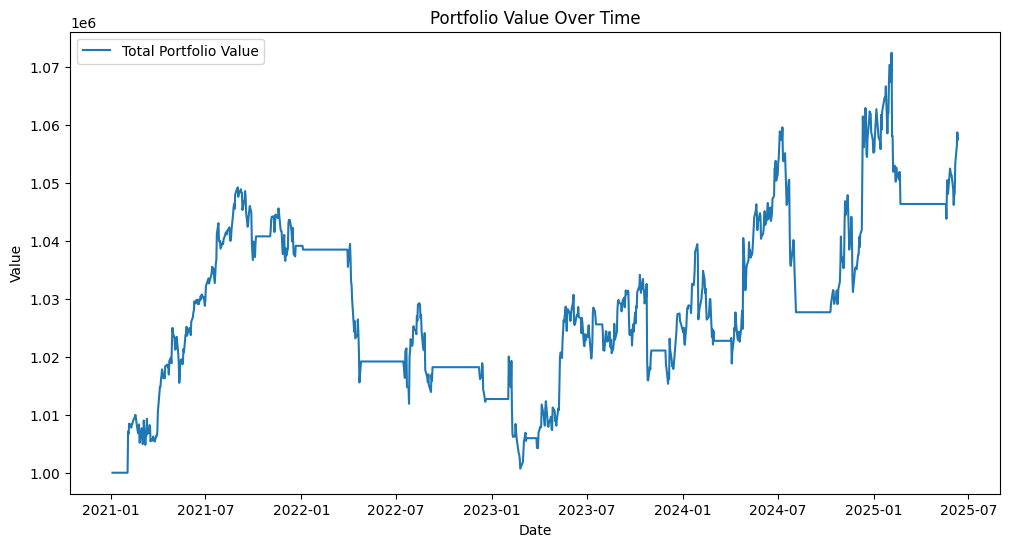

In [5]:
def backtest_strategy(data, signals):
    initial_capital = 1000000

    # Ensure 'Adj Close' exists, otherwise use 'Close'
    price_column = 'Adj Close' if 'Adj Close' in data.columns else 'Close'

    positions = pd.DataFrame(index=data.index).fillna(0.0)
    positions[stock_symbol] = 1000 * signals['signal']  # Assuming 1000 shares per trade

    portfolio = positions.multiply(data[price_column], axis=0)
    pos_diff = positions.diff()

    portfolio['holdings'] = positions.multiply(data[price_column], axis=0).sum(axis=1).fillna(0.0)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(data[price_column], axis=0)).sum(axis=1).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    return portfolio

# Example usage
portfolio = backtest_strategy(stock_data, signals)

# Visualize the backtest results
plt.figure(figsize=(12, 6))
plt.plot(portfolio['total'], label='Total Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


**RESULTS DISPLAY**

In [6]:
total_returns = (portfolio['total'].iloc[-1] - portfolio['total'].iloc[0]) / portfolio['total'].iloc[0] * 100
sharpe_ratio = (portfolio['returns'].mean() / portfolio['returns'].std()) * np.sqrt(252)
accuracy = (signals['positions'].diff() == 0).sum() / len(signals) * 100

# Display results
print(f"\nTotal Returns: {total_returns:.2f}%")
print(f"\nAnnualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"\nAccuracy of Strategy: {accuracy:.2f}%")


Total Returns: 5.74%

Annualized Sharpe Ratio: 0.43

Accuracy of Strategy: 95.43%


Test MSE: 22.5391


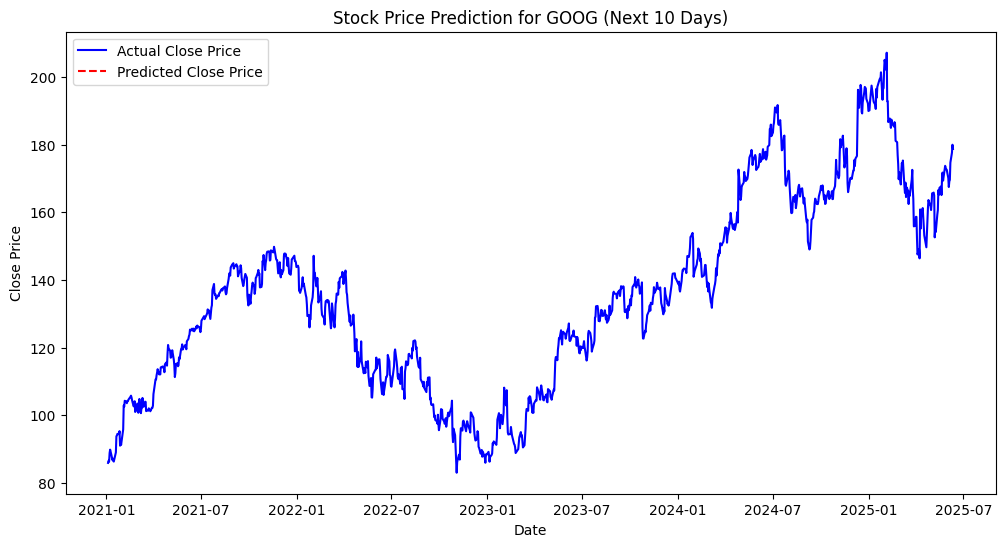

            Predicted_Close
Date                       
2025-06-12       179.954086


In [7]:
def prepare_data(data):
    data = data.copy()

    for col in data.columns:
        data[col] = data[col].values.flatten()

    data = add_all_ta_features(
        data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )

    for lag in range(1, 6):
        data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)

    data.dropna(inplace=True)

    return data

X = stock_data.drop(columns=['Close'])
y = stock_data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = XGBRegressor(objective='reg:squarederror', n_estimators=50000, learning_rate=0.002)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=1, freq='B')
future_features = pd.DataFrame(index=future_dates)

for col in X.columns:
    future_features[col] = stock_data[col].iloc[-1]

future_features = future_features.astype(float)
future_features = future_features.iloc[0].values.reshape(1, -1)

future_predictions = model.predict(future_features)

future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions})
future_df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label="Actual Close Price", color="blue")
plt.plot(future_df.index, future_df['Predicted_Close'], label="Predicted Close Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction for {stock_symbol} (Next 10 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

print(future_df)
